In [1]:
import os
import pandas as pd
from scipy.signal import savgol_filter
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from scipy.signal import savgol_filter
import numpy as np
import scipy.stats as stats
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [2]:

def read_and_label_files(directory, activity_prefix):
    data_list = []
    for filename in os.listdir(directory):
        if filename.startswith(activity_prefix) and filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            data = smooth_data(data)  # Applying smoothing filter
            data['activity'] = activity_prefix  # Using the activity prefix as the label
            data_list.append(data)
    return pd.concat(data_list, ignore_index=True)

def smooth_data(data):
    for column in ['x', 'y', 'z']:
        data[column] = savgol_filter(data[column], window_length=15, polyorder=3)
    return data

def segment_into_windows(data, points_per_window):
    windows = []
    for start in range(0, len(data), points_per_window):
        end = start + points_per_window
        # Discarding the last window if it has fewer points than `points_per_window`
        if end <= len(data):
            window = data.iloc[start:end]
            windows.append(window)
    return windows

# Example usage
walking_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Walking', 'walking')
sitting_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Sitting', 'sitting')
running_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Running', 'running')
rotating_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Rotating', 'rotating')
standing_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Standing', 'standing')
liftUp_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/ElevatorUp', 'liftUp')
liftDown_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/ElevatorDown', 'liftDown')
# stairUp_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/StairUp', 'stairUp')
# stairDown_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/StairDown', 'stairDown')
sweeping_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Sweeping', 'sweeping')
bodyrotating_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/BodyRotating', 'bodyrotating')
# driving_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Driving', 'Driving')
waving_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Waving', 'waving')
liftwt_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/liftingwt', 'liftwt')



# driving_data,  stairUp_data, stairDown_data,
# Combine all data 
all_data = pd.concat([walking_data, sitting_data,running_data,rotating_data,standing_data,liftUp_data, liftDown_data, sweeping_data, bodyrotating_data,liftwt_data,waving_data], ignore_index=True)
all_data.shape

# Segmenting into windows
points_per_window = 58 * 2  # 58 Hz * 2 seconds
windows = segment_into_windows(all_data, points_per_window)

# Now, `windows` is a list where each element is a DataFrame representing a 2-second window
print(f"Number of windows: {len(windows)}")
print(f"Number of Data's (Rows, Col): {all_data.shape}")
activity_counts = all_data['activity'].value_counts()
print(activity_counts)


Number of windows: 2686
Number of Data's (Rows, Col): (311663, 6)
activity
walking         76444
standing        51381
liftDown        39879
waving          32043
liftUp          31388
running         23915
sitting         23184
sweeping        22126
bodyrotating     6940
liftwt           2472
rotating         1891
Name: count, dtype: int64


In [3]:

def extract_features(window):
    features = {}
    
    if 'activity' in window.columns:
        features['activity'] = window['activity'].iloc[0]
    
    # Statistical features
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_var'] = np.var(data)
        features[f'{axis}_median'] = np.median(data)
        features[f'{axis}_skew'] = stats.skew(data)
        features[f'{axis}_kurtosis'] = stats.kurtosis(data)
    
    # Time-domain features
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
        features[f'{axis}_zero_crossing_rate'] = np.sum(np.diff(np.sign(data)) != 0) / len(data)
        features[f'{axis}_sma'] = np.sum(np.abs(data))
        features[f'{axis}_energy'] = np.sum(data**2)

        # Entropy (using histogram for probability distribution)
        hist, bin_edges = np.histogram(data, bins=10, density=True)
        hist = np.nan_to_num(hist, nan=0.0)  # Replace NaN with 0
        hist = hist / hist.sum()  # Normalize to create a probability distribution
        entropy = -np.sum(hist * np.log2(hist + 1e-9))  # Log of zero handled by adding a small value (1e-9)
        features[f'{axis}_entropy'] = entropy
    
    # Frequency-domain features (using FFT)
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        fft_values = np.fft.fft(data)
        fft_values = np.abs(fft_values)
        dominant_frequency = np.argmax(fft_values)
        spectral_entropy = -np.sum((fft_values / np.sum(fft_values)) * np.log2(fft_values / np.sum(fft_values) + 1e-9))
        features[f'{axis}_dominant_frequency'] = dominant_frequency
        features[f'{axis}_spectral_entropy'] = spectral_entropy
    
    return features


window_features = [extract_features(window) for window in windows]

# Now, `window_features` is a list where each element is a dictionary containing features for a window


In [4]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Convert the list of feature dictionaries to a DataFrame
feature_df = pd.DataFrame(window_features)

# Assuming 'activity' is a column in your DataFrame representing the label
# If it's not, you should add this column to 'feature_df'

# Separating features and target variable
X = feature_df.drop('activity', axis=1)  # Features
y = feature_df['activity']  # Target variable (activity labels)


In [5]:
feature_df.head()
activity_counts = feature_df['activity'].value_counts()
print(activity_counts)


activity
walking         659
standing        443
liftDown        344
waving          275
liftUp          270
running         207
sitting         200
sweeping        191
bodyrotating     60
liftwt           21
rotating         16
Name: count, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

#shuffle=True,stratify=y

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Model Training
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Model Evaluation
print(f"Random forest Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Random forest Accuracy: 93.05%
              precision    recall  f1-score   support

bodyrotating       1.00      1.00      1.00        20
    liftDown       0.78      0.81      0.80       113
      liftUp       0.70      0.64      0.67        75
      liftwt       0.86      1.00      0.92         6
    rotating       1.00      1.00      1.00         4
     running       0.98      1.00      0.99        61
     sitting       1.00      1.00      1.00        56
    standing       0.99      0.98      0.99       131
    sweeping       0.98      0.93      0.95        57
     walking       0.99      1.00      0.99       206
      waving       0.97      0.97      0.97        77

    accuracy                           0.93       806
   macro avg       0.93      0.94      0.94       806
weighted avg       0.93      0.93      0.93       806



In [7]:
y_test.value_counts()

activity
walking         136
standing         88
liftDown         75
waving           50
liftUp           49
running          45
sitting          38
sweeping         35
bodyrotating     14
liftwt            5
rotating          3
Name: count, dtype: int64

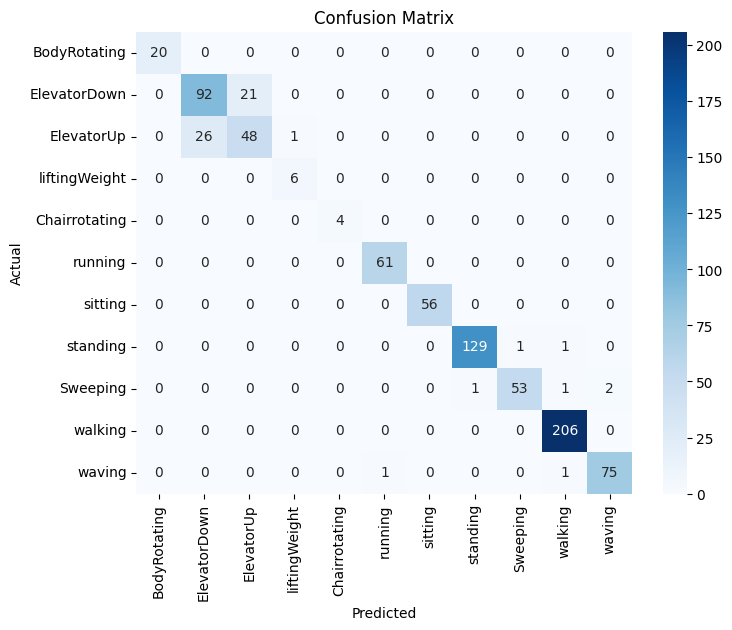

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
confusion = confusion_matrix( y_test, y_pred)

# Define class/activity labels
#'Driving',  'stairDown','StairsUp',
class_labels = ['BodyRotating','ElevatorDown','ElevatorUp','liftingWeight','Chairrotating','running', 'sitting','standing', 'Sweeping','walking','waving' ] 

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from joblib import dump

# Save the model to a file
model_filename = 'HAR1_trained_model.joblib'
dump(rf_model, model_filename)


['HAR1_trained_model.joblib']

In [17]:
from joblib import load

# Load the model from the file|
rf_model = load(model_filename)


In [11]:
rf_model

RandomForestClassifier(n_estimators=300, random_state=42)

In [20]:

unseen_data = pd.read_csv('Unseen/unseenCode.csv') 
smoothed_unseen_data = smooth_data(unseen_data)
# Segment into windows     
unseen_windows = segment_into_windows(unseen_data, points_per_window=58*2)
# Extract features from each window
unseen_window_features = [extract_features(window) for window in unseen_windows]
# Convert to DataFrame
unseen_feature_df = pd.DataFrame(unseen_window_features)
# Load the saved model
rf_model = load('HAR1_trained_model.joblib')
# Make predictions
unseen_predictions = rf_model.predict(unseen_feature_df)
# Now 'unseen_predictions' contains the predicted activities for each window
unseen_predictions
# unseen_feature_df.columns


array(['standing', 'standing', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'standing', 'sweeping', 'standing', 'walking', 'walking',
       'walking', 'standing', 'standing', 'standing'], dtype=object)

In [21]:

from collections import Counter
# Calculate the count of each activity
activity_counts = Counter(unseen_predictions)

# Calculate the total count of all activities
total_count = len(unseen_predictions)

# Calculate the percentage of each activity
activity_percentages = {activity: count / total_count * 100 for activity, count in activity_counts.items()}

# Print the counts and percentages
for activity, count in activity_counts.items():
    percentage = activity_percentages[activity]
    print(f'{activity}: Count={count}, Percentage={percentage:.2f}%')
unseen_predictions

standing: Count=7, Percentage=17.95%
walking: Count=31, Percentage=79.49%
sweeping: Count=1, Percentage=2.56%


array(['standing', 'standing', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'standing', 'sweeping', 'standing', 'walking', 'walking',
       'walking', 'standing', 'standing', 'standing'], dtype=object)